In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from DLC_for_WBFM.utils.projects.finished_project_data import ProjectData
import napari
import pandas as pd
import numpy as np
from DLC_for_WBFM.utils.feature_detection.class_frame_pair import FramePair
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from DLC_for_WBFM.utils.postures.centerline_pca import WormFullVideoPosture, WormSinglePosture
from DLC_for_WBFM.utils.external.centerline_utils import transform_neuron_point_cloud


Bad key "text.kerning_factor" on line 4 in
/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [3]:
# fname = "/scratch/zimmer/Charles/dlc_stacks/worm3-tracklet_wiggle/project_config.yaml"
fname = "/home/charles/dlc_stacks/worm3-newseg-2021_11_17/project_config.yaml"

project_data = ProjectData.load_final_project_data_from_config(fname, to_load_tracklets=True)

Output files: /home/charles/dlc_stacks/worm3-newseg-2021_11_17/3-tracking/manual_annotation/global2tracklet_manual.pickle, /home/charles/dlc_stacks/worm3-newseg-2021_11_17/3-tracking/manual_annotation/manually_split_tracklets.h5, /home/charles/dlc_stacks/worm3-newseg-2021_11_17/3-tracking/manual_annotation/split_names.pickle, /home/charles/dlc_stacks/worm3-newseg-2021_11_17/3-tracking/manual_annotation/split_times.pickle
Project data for directory:
/home/charles/dlc_stacks/worm3-newseg-2021_11_17 
Found the following raw data files:
red_data: True
green_data: True
============Segmentation===============
raw_segmentation: True
segmentation: True
============Tracklets==================
df_training_tracklets: False
reindexed_masks_training: True
============Traces=====================
red_traces: True
green_traces: True
final_tracks: True
behavior_annotations: True



In [4]:

fname1 = "/project/neurobiology/zimmer/wbfm/centerline/wbfm_ulises_centerline_for_charlie/2021-03-04_16-17-30_worm3_ZIM2051-_spline_X_coords.csv"
fname2 = "/project/neurobiology/zimmer/wbfm/centerline/wbfm_ulises_centerline_for_charlie/2021-03-04_16-17-30_worm3_ZIM2051-_spline_Y_coords.csv"
fname3 = "/project/neurobiology/zimmer/wbfm/centerline/wbfm_ulises_centerline_for_charlie/2021-03-04_16-17-30_worm3_ZIM2051-_spline_K.csv"

worm_posture = WormFullVideoPosture(fname1, fname2, fname3)

# Scratch: Use a transformer to encode

In [5]:
t = 0
def build_worm_at_time(t):
    pts0 = transform_neuron_point_cloud(project_data.get_centroids_as_numpy(t))
    centerline0 = worm_posture.get_centerline_for_time(t)
    return WormSinglePosture(pts0, centerline0)

In [6]:
n_neighbors = 20
i_anchor = 50

n0 = worm0.get_neighbors_in_local_coordinate_system(i_anchor=i_anchor, n_neighbors=n_neighbors)

In [7]:
n0.shape

(20, 3)

In [8]:
import torch
from self_attention_cv import AxialAttentionBlock

In [9]:

model = RectAxialAttentionBlock(in_channels=1, dim_h=20, dim_w=3, heads=8)
# x = torch.rand(1, 256, 20, 20)  # [batch, tokens, dim, dim]
t_n0 = torch.unsqueeze(torch.from_numpy(np.array([n0])), dim=0).float()
y = model(t_n0)


NameError: name 'RectAxialAttentionBlock' is not defined

In [ ]:

model = RectAxialEncoder(in_channels=1, dim_h=20, dim_w=3, heads=8)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

y = model(t_n0.to(device))
y

# Build a student and teacher model

In [352]:
import time
from torch.utils.data import DataLoader


In [ ]:

# Get test data
# i_anchor = 0
# test_data = []
# for i_anchor in range(len(worm0.neuron_zxy)):
#     pts = worm0.get_neighbors_in_local_coordinate_system(i_anchor=i_anchor, n_neighbors=n_neighbors)
#     test_data.append(torch.from_numpy(np.expand_dims(pts, axis=0)))

In [373]:
def build_worm_at_time(t):
    pts0 = transform_neuron_point_cloud(project_data.get_centroids_as_numpy(t))
    centerline0 = worm_posture.get_centerline_for_time(t)
    return WormSinglePosture(pts0, centerline0)

# ============ preparing data ... ============
n_neighbors = dim_h = 50
dim_w = 3
batch_sz = 1
local_crops_number = 2

augmentation = PointCloudAugmentationDINO(
    global_crops_scale=1, 
    local_crops_scale=3, 
    local_crops_number=local_crops_number
)

class PointCloudDataset():
    
    def __init__(self, augmentation, num_volumes=1, start_volume=0):
        
        preloaded_data = []
        for t in tqdm(range(start_volume, start_volume+num_volumes)):
            worm = build_worm_at_time(t)
            try:
                for i_anchor in range(len(worm0.neuron_zxy)):
                    pts = worm.get_neighbors_in_local_coordinate_system(i_anchor=i_anchor, n_neighbors=n_neighbors)
                    preloaded_data.append(torch.from_numpy(np.expand_dims(pts, axis=0)))
            except IndexError:
                print("skipped an index error")
                pass
        
        self.preloaded_data = preloaded_data
        self.augmentation = augmentation
    
    def __len__(self):
        return len(self.preloaded_data)

    def __getitem__(self, idx):
        return self.augmentation(self.preloaded_data[idx]), None

training_data = PointCloudDataset(augmentation, num_volumes=40)
# train_dataloader = DataLoader(training_data, batch_size=1, shuffle=True)
test_data = PointCloudDataset(augmentation, num_volumes=10, start_volume=100)
# test_dataloader = DataLoader(test_data, batch_size=1, shuffle=True)

  0%|          | 0/40 [00:00<?, ?it/s]

skipped an index error
skipped an index error
skipped an index error
skipped an index error


  0%|          | 0/10 [00:00<?, ?it/s]

In [178]:
# ============ building student and teacher networks ... ============
model_opt = dict(in_channels=batch_sz, dim_h=n_neighbors, dim_w=3, heads=8)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

student = RectAxialEncoder(**model_opt).to(device)
teacher = RectAxialEncoder(**model_opt).to(device)

# teacher and student start with the same weights
teacher.load_state_dict(student.state_dict())
# there is no backpropagation through the teacher, so no need for gradients
for p in teacher.parameters():
    p.requires_grad = False

print("Initialized")

Initialized


In [357]:
# ============ preparing loss ... ============
nepochs = 10

args = dict(epochs=nepochs, clip_grad=False, freeze_last_layer=False)

dino_loss = DINOLoss(
    dim_h,
    dim_w,
    local_crops_number + 2,  # total number of crops = 2 global crops + local_crops_number
    nepochs=nepochs
).cuda()

In [358]:
lr = 0.001
wd = 1e-5
momentum = 0.9

optimizer = torch.optim.Adam(student.parameters(), lr = lr, weight_decay = wd)

In [ ]:
import math
from tqdm.auto import tqdm

start_epoch = 0

start_time = time.time()
print("Starting DINO training !")
for epoch in tqdm(range(start_epoch, args['epochs'])):
    # data_loader.sampler.set_epoch(epoch)

    # ============ training one epoch of DINO ... ============
    train_stats = train_one_epoch(student, teacher, None, dino_loss, training_data,
                    optimizer, lr, wd, momentum, epoch,
                    None, args)

    # ============ writing logs ... ============
    save_dict = {
        'student': student.state_dict(),
        'teacher': teacher.state_dict(),
        'optimizer': optimizer.state_dict(),
        'epoch': epoch + 1,
        'args': args,
        'dino_loss': dino_loss.state_dict(),
    }
#     if fp16_scaler is not None:
#         save_dict['fp16_scaler'] = fp16_scaler.state_dict()
        
#     utils.save_on_master(save_dict, os.path.join(args.output_dir, 'checkpoint.pth'))
#     if args.saveckp_freq and epoch % args.saveckp_freq == 0:
#         utils.save_on_master(save_dict, os.path.join(args.output_dir, f'checkpoint{epoch:04}.pth'))
    # log_stats = {**{f'train_{k}': v for k, v in train_stats.items()},
    #              'epoch': epoch}

Starting DINO training !


  0%|          | 0/10 [00:00<?, ?it/s]

# Apply to next volume using knn

In [313]:
all_embeddings = [teacher(torch.unsqueeze(dat.float(), dim=0).to(device)).to('cpu') for dat in test_data]

In [338]:
t = 0
worm0 = build_worm_at_time(t)

# Get next data
first_data = []
for i_anchor in range(len(worm0.neuron_zxy)):
    pts = worm0.get_neighbors_in_local_coordinate_system(i_anchor=i_anchor, n_neighbors=n_neighbors)
    first_data.append(torch.from_numpy(np.expand_dims(pts, axis=0)))

all_first_embeddings = [teacher(torch.unsqueeze(dat.float(), dim=0).to(device)).to('cpu') for dat in first_data]

t = 1
worm1 = build_worm_at_time(t)

# Get next data
next_data = []
for i_anchor in range(len(worm0.neuron_zxy)):
    pts = worm1.get_neighbors_in_local_coordinate_system(i_anchor=i_anchor, n_neighbors=n_neighbors)
    next_data.append(torch.from_numpy(np.expand_dims(pts, axis=0)))

all_next_embeddings = [teacher(torch.unsqueeze(dat.float(), dim=0).to(device)).to('cpu') for dat in next_data]

In [339]:
def flatten_embeddings(list_of_embedding):
    flat_list = [np.reshape(np.squeeze(emb), (-1, 1)).numpy() for emb in list_of_embedding]
    return np.hstack(flat_list).T
    

In [340]:
all_v1_embeddings = flatten_embeddings(all_next_embeddings)
all_v0_embeddings = flatten_embeddings(all_first_embeddings)

In [341]:
from sklearn.neighbors import NearestNeighbors

v0_neighbor_obj = NearestNeighbors(n_neighbors=10).fit(all_v0_embeddings)

matches_with_conf = []
for i, embedding1 in enumerate(all_v1_embeddings):
    closest_dist, closest_ind = v0_neighbor_obj.kneighbors(np.reshape(embedding1, (1, -1)), 1)
    matches_with_conf.append((i, closest_ind[0][0], closest_dist[0][0]))

In [345]:
# matches_with_conf

In [350]:
from DLC_for_WBFM.utils.pipeline.matches_class import MatchesWithConfidence 
from scipy.spatial import distance

dino_dist = distance.cdist(all_v1_embeddings, all_v0_embeddings)
dino_matches = MatchesWithConfidence.matches_from_distance_matrix(dino_dist)
# dino_matches.get_mapping_0_to_1()

In [351]:
# project_data.raw_matches[(0,1)].final_matches

In [321]:
# Plot PCA projections
from sklearn.decomposition import PCA

pca = PCA(n_components=2, whiten=True).fit(all_v0_embeddings)
pca_proj_v0 = pca.transform(all_v0_embeddings)
pca_proj_v1 = pca.transform(all_v1_embeddings)


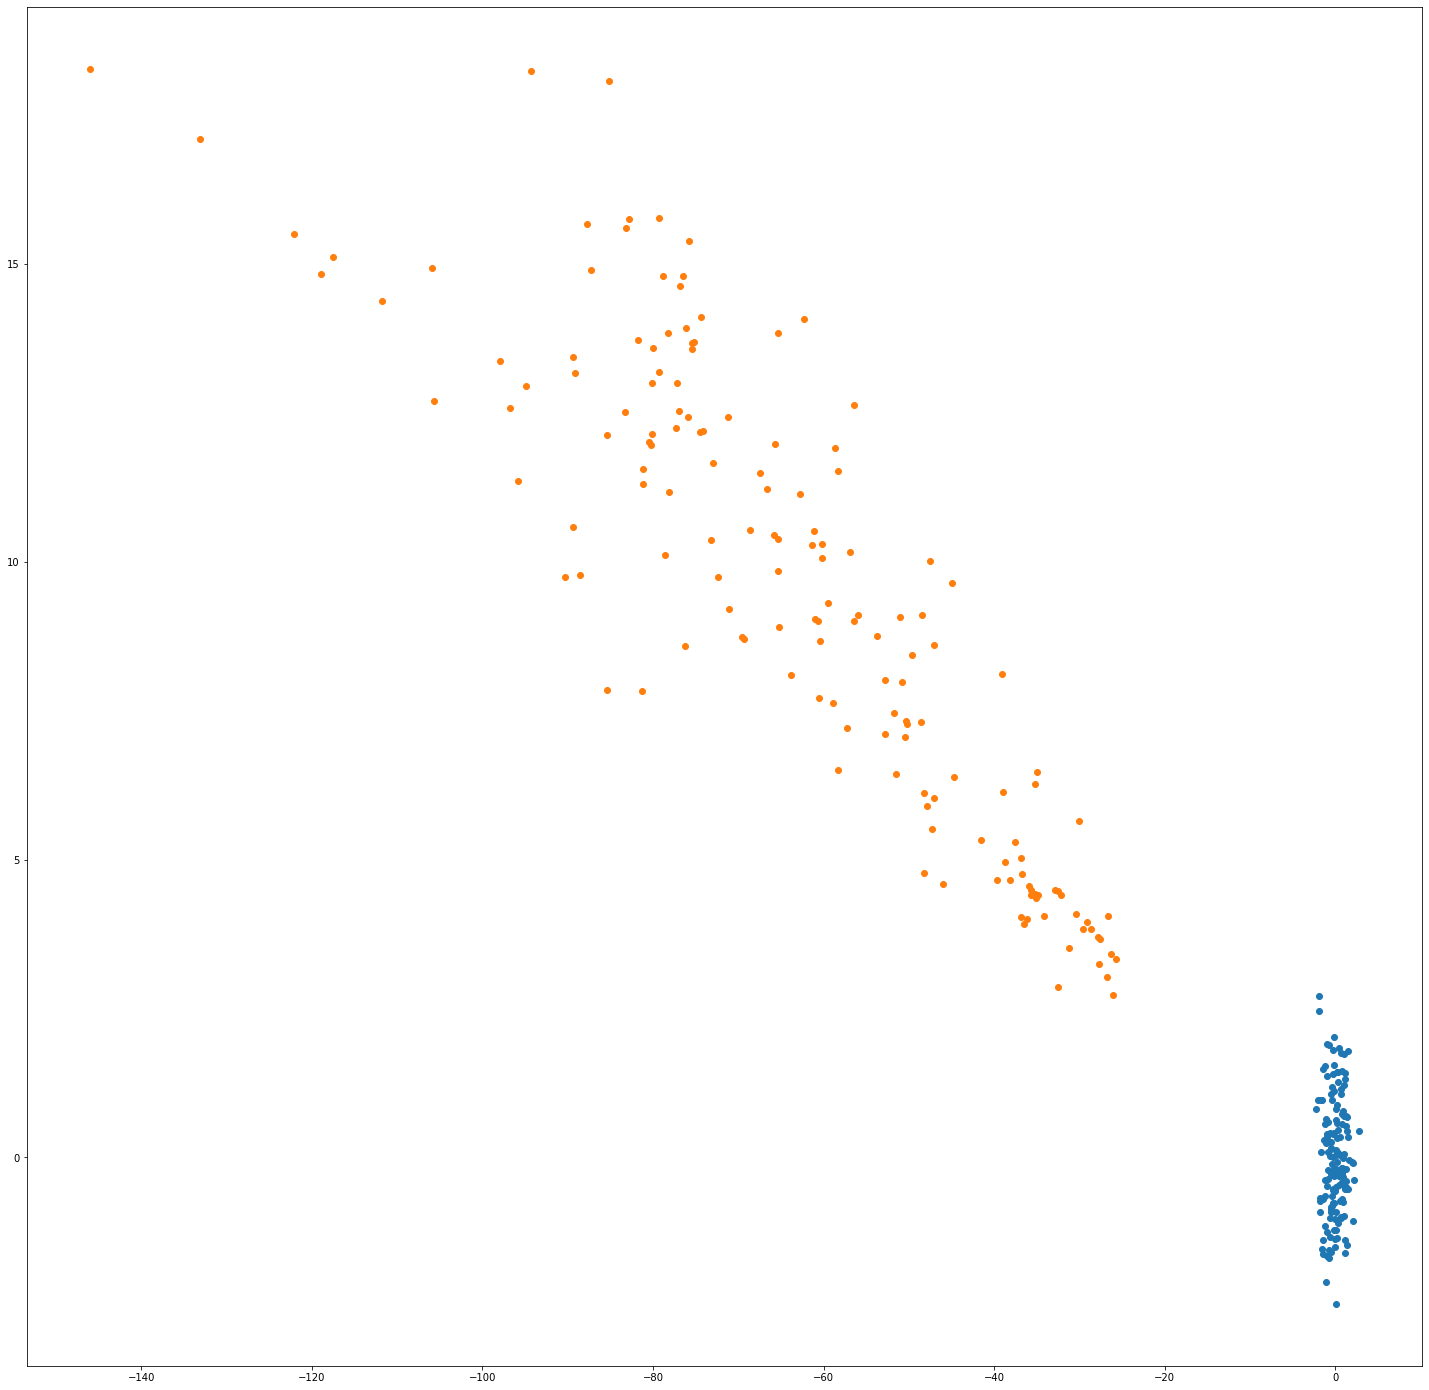

In [322]:
plt.figure(figsize=(25,25))
plt.plot(pca_proj_v0[:, 0], pca_proj_v0[:, 1], 'o')
plt.plot(pca_proj_v1[:, 0], pca_proj_v1[:, 1], 'o')

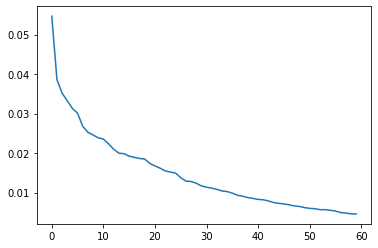

In [324]:
pca = PCA(n_components=60, whiten=True).fit(all_v0_embeddings)
plt.plot(pca.explained_variance_ratio_)

In [274]:
# project_data.napari_of_single_match((0,1))

# t-SNE instead of PCA

In [335]:
from sklearn.manifold import TSNE

tsne_embeddings = TSNE(n_components=2, init='random').fit_transform(all_v0_embeddings.T)
# tsne_proj_v0 = tsne.transform(all_v0_embeddings)
# tsne_proj_v1 = tsne.transform(all_v1_embeddings)

In [336]:
tsne_embeddings.shape

(150, 2)

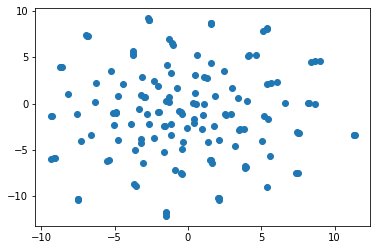

In [337]:
plt.plot(tsne_embeddings[:, 0], tsne_embeddings[:, 1], 'o')

# Rewrite the axial attention block to deal with rectangular input

In [10]:
from einops import rearrange
from torch import nn

from self_attention_cv import AxialAttention

def _conv2d1x1(in_channels, out_channels, stride=1):
    """1x1 convolution for contraction and expansion of the channels dimension
    conv is followed by batch norm"""
    return nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                         nn.BatchNorm2d(out_channels))


class RectAxialAttentionBlock(nn.Module):
    def __init__(self, in_channels, dim_h, dim_w, heads=8, dim_head=None):
        """
        Slight modification: different dims for x and y
        
        Axial-attention block implementation as described in:
        paper: https://arxiv.org/abs/2003.07853 , Fig. 2 page 7
        blogpost: TBA
        official code: https://github.com/csrhddlam/axial-deeplab
        Args:
            in_channels:
            dim: token's dim
            heads: the number of distict head representations
            axial_att: whether to use axial att or MHSA
            dim_head: for MHSA only
        """
        super().__init__()
        self.dim_h = dim_h
        self.dim_w = dim_w
        self.heads = heads
        d_in = 128  # hardcoded

        # brings the input channels to 128 feature maps
        self.in_conv1x1 = _conv2d1x1(in_channels, d_in)
        self.out_conv1x1 = _conv2d1x1(d_in, in_channels)
        self.relu = nn.ReLU(inplace=True)

        self.dim_head = d_in // self.heads
        self.height_att = AxialAttention(dim=dim_h, in_channels=d_in, heads=heads)
        self.width_att = AxialAttention(dim=dim_w, in_channels=d_in, heads=heads)

    def forward(self, x_in):
        assert x_in.dim() == 4, f'Ensure your input is 4D: [batch,channels, height,width], not {x_in.dim()}'
        x = self.relu(self.in_conv1x1(x_in))
        # merge batch dim with width
        x = rearrange(x, 'b c h w -> (b w) c h')
        x = self.height_att(x)
        # decompose width + merge batch with height
        x = rearrange(x, '(b w) c h  -> (b h) c w', w=self.dim_w)
        x = self.relu(self.width_att(x))
        x = rearrange(x, '(b h) c w -> b c h w', h=self.dim_h)
        return self.relu(self.out_conv1x1(x) + x_in)

In [11]:
class RectAxialEncoder(nn.Module):
    """
    Uses just RectAxialAttentionBlock blocks instead of regular transformers
    """
    
    def __init__(self, in_channels, dim_h, dim_w, blocks=6, heads=8, dim_head=None):
        super().__init__()
        self.block_list = [RectAxialAttentionBlock(in_channels, dim_h, dim_w, heads, dim_head) for _ in range(blocks)]
        self.layers = nn.ModuleList(self.block_list)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [156]:
from torchvision import transforms
from torch import nn

class ReplaceRandomPoint(nn.Module):
    def __init__(self, num_to_replace=1, scale=1, DEBUG=False):
        self.num_to_replace = num_to_replace
        self.scale = scale
        self.DEBUG = DEBUG
    
    def __call__(self, pts):
        i_to_replace = torch.randperm(pts.shape[0])[:self.num_to_replace]
        pt_sz = pts[0].shape
        if self.DEBUG:
            print(i_to_replace)
            print("Original points: ", pts)
        
        for i in i_to_replace:
            new_pt = self.scale * torch.rand(pt_sz)
            pts[i, :] = new_pt
            if self.DEBUG:
                print(new_pt)
            
        return pts

            
class PointCloudAugmentationDINO(object):
    """
    Following augmentations:
        Replace neuron with outlier
        Add jitter to location
        Scale
    TODO:
        RandomAffine
        (see: https://pytorch3d.readthedocs.io/en/latest/modules/transforms.html)
    """
    def __init__(self, global_crops_scale, local_crops_scale, local_crops_number):
        normalize = nn.Sequential(
            transforms.Normalize(0.0, 0.229),
        )
        # normalize = transforms.Compose([
        #     transforms.ToTensor(),
        #     # transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        # ])
        
        replace_single_random = ReplaceRandomPoint(num_to_replace=1, scale=global_crops_scale)
        replace_many_random = ReplaceRandomPoint(num_to_replace=5, scale=local_crops_scale)

        # first global crop
        self.global_transfo1 = nn.Sequential(
            replace_single_random,
            normalize,
            # torch.squeeze # Output has a middle dimension of 1 for some reason
        )
        # second global crop
        self.global_transfo2 = nn.Sequential(
            replace_single_random,
            normalize,
            # torch.squeeze
        )
        # transformation for the local small crops
        self.local_crops_number = local_crops_number
        self.local_transfo = nn.Sequential(
            replace_many_random,
            normalize,
            # torch.squeeze
        )

    def __call__(self, pts):
        crops = []
        crops.append(self.global_transfo1(pts))
        crops.append(self.global_transfo2(pts))
        for _ in range(self.local_crops_number):
            crops.append(self.local_transfo(pts))
        # Return full shape
        crops = torch.cat([torch.unsqueeze(c, dim=0).float() for c in crops], dim=0)
        # for c in crops:
        #     c = torch.unsqueeze(c, dim=0)
        return crops

In [98]:

import torch.nn.functional as F
# import torch.distributed as dist

class DINOLoss(nn.Module):
    def __init__(self, dim_h, dim_w, ncrops, warmup_teacher_temp=0.04, teacher_temp=0.04,
                 warmup_teacher_temp_epochs=0, nepochs=10, student_temp=0.1,
                 center_momentum=0.9):
        super().__init__()
        self.student_temp = student_temp
        self.center_momentum = center_momentum
        self.ncrops = ncrops
        # Will be same size as the output of a block; in this case, 2d
        self.register_buffer("center", torch.zeros(1, dim_h, dim_w))
        # we apply a warm up for the teacher temperature because
        # a too high temperature makes the training instable at the beginning
        self.teacher_temp_schedule = np.concatenate((
            np.linspace(warmup_teacher_temp,
                        teacher_temp, warmup_teacher_temp_epochs),
            np.ones(nepochs - warmup_teacher_temp_epochs) * teacher_temp
        ))

    def forward(self, student_output, teacher_output, epoch):
        """
        Cross-entropy between softmax outputs of the teacher and student networks.
        """
        student_out = student_output / self.student_temp
        student_out = student_out.chunk(self.ncrops)

        # teacher centering and sharpening
        temp = self.teacher_temp_schedule[epoch]
        teacher_out = F.softmax((teacher_output - self.center) / temp, dim=-1)
        teacher_out = teacher_out.detach().chunk(2)

        total_loss = 0
        n_loss_terms = 0
        for iq, q in enumerate(teacher_out):
            for v in range(len(student_out)):
                if v == iq:
                    # we skip cases where student and teacher operate on the same view
                    continue
                loss = torch.sum(-q * F.log_softmax(student_out[v], dim=-1), dim=-1)
                total_loss += loss.mean()
                n_loss_terms += 1
        total_loss /= n_loss_terms
        self.update_center(teacher_output)
        return total_loss

    @torch.no_grad()
    def update_center(self, teacher_output):
        """
        Update center used for teacher output.
        """
        batch_center = torch.sum(teacher_output, dim=0, keepdim=True)
        batch_center = batch_center / len(teacher_output)
        # dist.all_reduce(batch_center)
        # batch_center = batch_center / (len(teacher_output) * dist.get_world_size())

        # ema update
        self.center = self.center * self.center_momentum + batch_center * (1 - self.center_momentum)

In [223]:
def train_one_epoch(student, teacher, _teacher_without_ddp, dino_loss, data_loader,
                    optimizer, lr, wd, momentum, epoch,
                    fp16_scaler, args):
    # metric_logger = utils.MetricLogger(delimiter="  ")
    # header = 'Epoch: [{}/{}]'.format(epoch, args.epochs)
    for it, (images, _) in enumerate(data_loader):
        # update weight decay and learning rate according to their schedule
        it = len(data_loader) * epoch + it  # global training iteration
        for i, param_group in enumerate(optimizer.param_groups):
            # param_group["lr"] = lr_schedule[it]
            param_group["lr"] = lr
            if i == 0:  # only the first group is regularized
                # param_group["weight_decay"] = wd_schedule[it]
                param_group["weight_decay"] = wd

        # move images to gpu
        images = [im.cuda(non_blocking=True) for im in images]
        images = torch.unsqueeze(torch.cat(images), dim=1)
        # teacher and student forward passes + compute dino loss
        with torch.cuda.amp.autocast(fp16_scaler is not None):
            teacher_output = teacher(images[:2])  # only the 2 global views pass through the teacher
            student_output = student(images)
            loss = dino_loss(student_output, teacher_output, epoch)

        if not math.isfinite(loss.item()):
            print("Loss is {}, stopping training".format(loss.item()))
            sys.exit(1)
        # else:
        #     print("Loss is {}".format(loss.item()))
            
        # student update
        optimizer.zero_grad()
        param_norms = None
        if fp16_scaler is None:
            loss.backward()
            if args['clip_grad']:
                param_norms = utils.clip_gradients(student, args['clip_grad'])
            # utils.cancel_gradients_last_layer(epoch, student,
            #                                   args['freeze_last_layer'])
            optimizer.step()
        else:
            fp16_scaler.scale(loss).backward()
            if args['clip_grad']:
                fp16_scaler.unscale_(optimizer)  # unscale the gradients of optimizer's assigned params in-place
                param_norms = utils.clip_gradients(student, args['clip_grad'])
            utils.cancel_gradients_last_layer(epoch, student,
                                              args['freeze_last_layer'])
            fp16_scaler.step(optimizer)
            fp16_scaler.update()

        # EMA update for the teacher
        with torch.no_grad():
            # m = momentum_schedule[it]  # momentum parameter
            m = momentum
            for param_q, param_k in zip(student.parameters(), teacher.parameters()):
                param_k.data.mul_(m).add_((1 - m) * param_q.detach().data)

        # logging
        torch.cuda.synchronize()
        # metric_logger.update(loss=loss.item())
        # metric_logger.update(lr=optimizer.param_groups[0]["lr"])
        # metric_logger.update(wd=optimizer.param_groups[0]["weight_decay"])
    print("Loss is {}".format(loss.item()))
    # gather the stats from all processes
    # metric_logger.synchronize_between_processes()
    # print("Averaged stats:", metric_logger)
    # return {k: meter.global_avg for k, meter in metric_logger.meters.items()}

In [52]:
aug = PointCloudAugmentationDINO(10, 1, 2)

out = aug(torch.from_numpy(np.expand_dims(n0, axis=0)))

In [53]:
out[0].shape

torch.Size([1, 20, 3])

In [54]:
torch.unsqueeze(out[0], dim=0).shape

torch.Size([1, 1, 20, 3])

In [55]:
n0.shape

(20, 3)

In [56]:
f = ReplaceRandomPoint(1, 100, DEBUG=False)

f(n0).shape

(20, 3)

In [58]:
normalize = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(0.485, 0.229),
        ])

In [59]:
normalize(n0).shape

torch.Size([1, 20, 3])

In [60]:
normalize(f(n0)).shape

torch.Size([1, 20, 3])